In [2]:
#
# Machine Learning Fundamentals
# Hunter Merrill
# Spring 2025
# Mar 19, 2025
#

# -----------------------------------------------------------

import pandas as pd
import numpy as np
import math

# Training examples (x, f(x)) where x is a 2D vector
examples_list = [
    [1, 1], 1,
    [2, 4], 1,
    [3, 3], 1,
    [2, 3], 0,
    [2.5, 1], 0,
    [4, 2], 0,
    [5, 2], 0
]
# Convert examples to tuples & add to dictionary
training_examples = {}
for e in range(0, len(examples_list), 2):
  training_examples[tuple(examples_list[e])] = examples_list[e+1]



# Query instances
queries_list = [
    [1.5, 3],
    [3, 4],
    [4, 1]
]
queries = [tuple(q) for q in queries_list]

# Convert from 0/1 to -/+
def classify(query):
  classification = '?'

  match query:
    case 0:
      classification = '-'
    case 1:
      classification = '+'

  return classification

k Nearest Neighbors

```
Training:
  For each example (x, f(x)), add the example to the list training_examples

Classification:
  Given a query instance x_q to be classified,
    Let x_1 ... x_k denote the k instances from training_examples that are nearest to x_q
    Return f(x_q) <- argmax_(v in V) [sum^k_(i=1) [delta (v, f (x_i))]] where delta (a, b) is 1 if a=b and 0 otherwise.
```

In [3]:
closest = {} # Closest k points to each query
predictions = {} # Classification of each query
arg_weights = {} # Classification weights for each query



def knn(k, weighted = False):
  global training_examples, queries, closest, predictions, arg_weights

  # Print results
  def results():
    print('Classifications of query instances:')

    for xq in queries:
      closest_examples = [[x, classify(training_examples[x])] for x in closest[xq]] # List of k closest examples (x, f(x))
      print(f' {xq} -> {predictions[xq]}   Closest to {closest_examples}')
      if weighted:
        print(f'   Weights: -{arg_weights[xq][0]} +{arg_weights[xq][1]}')

  # Iterate through query instances
  for xq in queries:

      # Calculate Euclidian distances
      distances = {}
      for x in training_examples:
          distance = ((xq[0] - x[0]) ** 2 + (xq[1] - x[1]) ** 2) ** 0.5
          distances[x] = distance

      # Sort greatest to least, retain k closest
      dists = sorted(distances.items(), key=lambda item: item[1])[:k] # List of k (x, distance) tuples

      # Extract points from tuples
      closest[xq] = [t[0] for t in dists]

      # Weighted
      if weighted:
        arg_weights[xq] = {}

        for i in [0, 1]:
          # List of examples with classification=i
          match_i = []
          for t in dists:
            if training_examples[t[0]] == i:
              match_i.append(t)

          # Sum inverse squares
          arg_weights[xq][i] = sum([t[1] ** (-2) for t in match_i])

        # Determine classification
        max_arg = max(arg_weights[xq], key=arg_weights[xq].get)
        predictions[xq] = classify(max_arg)

      # Unweighted
      else:
        # Find average f(x) of closest points
        avg = sum([training_examples[x] for x in closest[xq]]) / k

        # Determine classification
        #   - if avg < 0.5 (more 0s)
        #   + if avg > 0.5 (more 1s)
        predictions[xq] = classify(int(avg + 0.5))

  results()

knn(1)
knn(5)
knn(5, weighted=True)

Classifications of query instances:
 (1.5, 3) -> -   Closest to [[(2, 3), '-']]
 (3, 4) -> +   Closest to [[(2, 4), '+']]
 (4, 1) -> -   Closest to [[(4, 2), '-']]
Classifications of query instances:
 (1.5, 3) -> +   Closest to [[(2, 3), '-'], [(2, 4), '+'], [(3, 3), '+'], [(1, 1), '+'], [(2.5, 1), '-']]
 (3, 4) -> -   Closest to [[(2, 4), '+'], [(3, 3), '+'], [(2, 3), '-'], [(4, 2), '-'], [(5, 2), '-']]
 (4, 1) -> -   Closest to [[(4, 2), '-'], [(5, 2), '-'], [(2.5, 1), '-'], [(3, 3), '+'], [(2, 3), '-']]
Classifications of query instances:
 (1.5, 3) -> -   Closest to [[(2, 3), '-'], [(2, 4), '+'], [(3, 3), '+'], [(1, 1), '+'], [(2.5, 1), '-']]
   Weights: -4.2 +1.4797385620915033
 (3, 4) -> +   Closest to [[(2, 4), '+'], [(3, 3), '+'], [(2, 3), '-'], [(4, 2), '-'], [(5, 2), '-']]
   Weights: -0.825 +2.0
 (4, 1) -> -   Closest to [[(4, 2), '-'], [(5, 2), '-'], [(2.5, 1), '-'], [(3, 3), '+'], [(2, 3), '-']]
   Weights: -2.069444444444444 +0.19999999999999998


Naive Bayes classifier

```
Training:
  Estimate P(v_j) and P(a_i | v_j)

Classification:
  Return v_NB = argmax_[v_j in V](P(v_j) * product_[i](P(a_i | v_j))
```

In [46]:
predictions = {} # Classification of each query
statistics = {} # Mean and variance for each (l, a) pair
V, A = [0, 1], [0, 1] # Classification values; Zero-indexed attribute indeces



def gnb():
  global training_examples, queries, predictions, V, A
  v_nb = {}

  # Print results
  def results():
    print('Classifications of query instances:')
    for xq in queries:
      print(xq, classify(v_nb[xq]))

  # Slide 6.43
  def Pr(a, i, j):
     mu = statistics[(j, i)][0] # mean
     s_sq = statistics[(j, i)][1] # sample var

     coeff = 1 / math.sqrt(2 * math.pi * s_sq)
     param = -1 * ((a - mu) ** 2 / (2 * s_sq))

     return coeff * math.exp(param)

  # Calculate P(y) & mean/variance for each (y, a) pair
  P_y = [None] * len(V)
  for y in V:
    # Subset examples where classification = l
    y_j = [x for x in training_examples.keys() if training_examples[x] == y]
    P_y[y] = len(y_j) / len(training_examples) # P(y)

    for i in A:
      # Get a_i for each example
      a_i = [x[i] for x in y_j]

      # print(f'{y}, {i}, {y_j}, {a_i}')

      mu = np.mean(a_i)
      s_sq = np.var(a_i, ddof=1) # Bessel's correction (sample variance)
      statistics[(y, i)] = (mu, s_sq)

  # Classifier (textbook equation 6.20)
  for xq in queries:
    v_nb[xq] = np.argmax([P_y[y] * math.prod([Pr(xq[i], i, y) for i in A]) for y in V])

  results()

gnb()

Classifications of query instances:
(1.5, 3) +
(3, 4) +
(4, 1) -


KNN Regression

```
Regression using the k-NN Rule.
  Return the value
    h(x_q) = sum_{i=1}^k (c(x_i)) / k
```

In [75]:
#
# Machine Learning Fundamentals
# Hunter Merrill
# Spring 2025
# Mar 19, 2025
#

# -----------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Training examples (x, f(x)) where x is a 2D vector
training_examples = {
    0.7: 2.4,
    0.9: 2.9,
    1.2: 3.2,
    2: 4.7,
    2.8: 7.7,
    3.4: 6.5,
    4.2: 3.7,
    5.1: 9.0
}

# Query instances
queries = [1.5, 4.5]

Classifications of query instances:
 1.5 -> 3.6   Closest to [[1.2, 3.2], [2, 4.7], [0.9, 2.9]]
 4.5 -> 6.3999999999999995   Closest to [[4.2, 3.7], [5.1, 9.0], [3.4, 6.5]]
Classifications of query instances:
 1.5 -> 3.488819875776398   Closest to [[1.2, 3.2], [2, 4.7], [0.9, 2.9]]
 4.5 -> 4.857722308892356   Closest to [[4.2, 3.7], [5.1, 9.0], [3.4, 6.5]]


<ipython-input-113-be22a981a6d6>:38: RuntimeWarning: divide by zero encountered in scalar divide
  arg_weights[t[0]] = 1/(t[1] ** 2)
<ipython-input-113-be22a981a6d6>:42: RuntimeWarning: invalid value encountered in scalar divide
  avg = sum([arg_weights[x] * training_examples[x] for x in closest[xq]]) / sum_weights


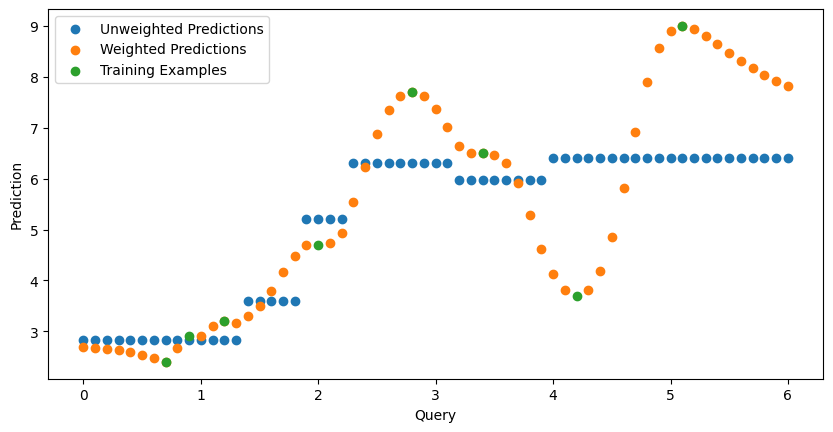

In [113]:
closest = {} # Closest k points to each query
predictions = {} # Classification of each query
arg_weights = {} # Classification weights for each query
queries = [1.5, 4.5]


def knn(k, weighted=False, show=True):
  global training_examples, queries, closest, predictions, arg_weights

  # Print results
  def results():
    print('Classifications of query instances:')

    for xq in queries:
      closest_examples = [[x, training_examples[x]] for x in closest[xq]] # List of k closest examples (x, f(x))
      print(f' {xq} -> {predictions[xq]}   Closest to {closest_examples}')

  # Iterate through query instances
  for xq in queries:

      # Calculate Euclidian distances
      distances = {}
      for x in training_examples:
        distance = np.abs(xq - x)
        distances[x] = distance

      # Sort greatest to least, retain k closest
      dists = sorted(distances.items(), key=lambda item: item[1])[:k] # List of k (instance, distance) tuples

      # Extract points from tuples
      closest[xq] = [t[0] for t in dists]

      # Weighted (Slide 6.30.2)
      if weighted:
        arg_weights = {}
        sum_weights = 0
        for t in dists:
          arg_weights[t[0]] = 1/(t[1] ** 2)
          sum_weights += arg_weights[t[0]]

        # Find average f(x) of closest points
        avg = sum([arg_weights[x] * training_examples[x] for x in closest[xq]]) / sum_weights
        predictions[xq] = avg

      # Unweighted
      else:
        # Find average f(x) of closest points (Slide 6.29)
        avg = sum([training_examples[x] for x in closest[xq]]) / k
        predictions[xq] = avg
  if show: results()

knn(3)
knn(3, weighted=True)


# Plot setup
fig, ax = plt.subplots(1)
fig.set_figwidth(10)
plt.xlabel('Query'); plt.ylabel('Prediction')

queries = np.arange(0.0, 6.1, 0.1)
predictions = {}

# Plot tics unweighted
knn(3, show=False)
ax.scatter(queries, predictions.values(), label="Unweighted Predictions")

# Plot tics weighted
knn(3, show=False, weighted=True)
ax.scatter(queries, predictions.values(), label="Weighted Predictions")

# Plot training examples
ax.scatter(training_examples.keys(), training_examples.values(), label="Training Examples")

ax.legend()
plt.show(); plt.close()